# Controlling Neural Networks with Rule Representations
## This notebook is derived from this paper by Seo et al.
https://arxiv.org/pdf/2106.07804.pdf

In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import random


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.beta import Beta

from utils_dp import DoublePendulum, calc_double_E, verification

from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

In [2]:
model_info = {'ruleonly': {},
              'dataonly': {},
              'dataonly-nobatch': {},
              'dataonly-nobatch-constraint1.0': {'constraint': 1.0},
              'dataonly-nobatch-constraint0.1': {'constraint': 0.1},
              'dataonly-nobatch-constraint0.01': {'constraint': 0.01},
              'paper': {'beta': [0.1], 'scale': 0, 'shared': True},
              'dnn-crr': {'beta': [0.1], 'scale': 1, 'shared': True},
              'dnn-crr-autoscale': {'beta': [0.1], 'scale': 0, 'shared': True}
             }

if not (os.path.exists("saved_models/")):
    os.makedirs("saved_models")
    print("created saved_model folder")

### Parameter of the experiment
#### Pendulum
L1 : Rod length 1, M1 : Mass 1
L2 : Rod length 2, M2 : Mass 2

Friction coefficients F1, F2

#### Initial condition for the  angles $\theta_1$ and  $\theta_2$ of the two pendulums are randomly sampled. Initial velocity is zero

![pendulum image](https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg )
#### Paramenter for the simulation
delta_t : time step for the simulation
tmax : max time





In [3]:
L1, L2, M1, M2, F1, F2 = 1, 1, 1, 5, 0.001, 0.001
    
init_theta1 = round(np.random.uniform(-np.pi/4, np.pi/4), 4)
init_omega1 = 0.0
init_theta2 = round(np.random.uniform(-np.pi/4, np.pi/4), 4)
init_omega2 = 0.0

tmax, dt = 3000, 0.005

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)

device = 'cuda:0'
seed = 42

# task paramenters
std_noise = 0.03  # noise added to trajectories
sampling_step = 30    # sample a row for every the step.

In [4]:
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.185600(10.634097),-0.281500(-16.128762)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)



In [5]:
y.shape

(600001, 4)

Text(0.5, 0, 'time (s)')

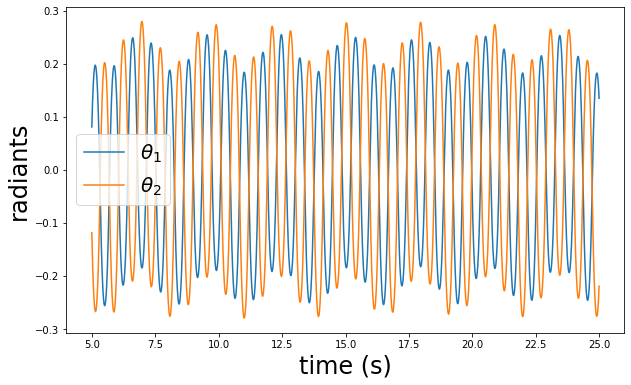

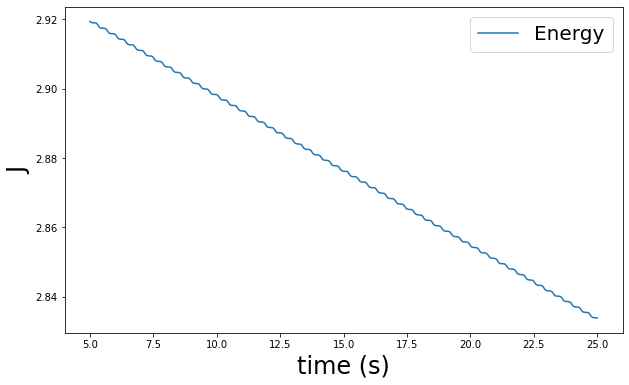

In [6]:
x_time = np.arange(y.shape[0])*dt
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[1000:5000],y[1000:5000,0],label = r"$\theta_1$")
ax.plot(x_time[1000:5000],y[1000:5000,2],label = r"$\theta_2$")
plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)

_, _, pred_E = calc_double_E(y[1000:5000,:], **dp_params) 

fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[1000:5000],pred_E,label = r"Energy")

plt.legend(fontsize=20)
ax.set_ylabel('J', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)

In [7]:
# Fine dt for generation and subsample for learning

sampling_dt = dt*sampling_step
sampling_ind = np.arange(0, t.shape[0] - 1, sampling_step)
sampling_t = t[sampling_ind]

input_output_y = np.concatenate((y[:-1], y[1:]), axis=1)    # [[input, output]]
X = input_output_y[sampling_ind]
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

subsampled sequence length: 20000 (3000 sec)
sampling dt: 0.15 (sec)


Text(0.5, 1.0, 'Subsampled trajectories')

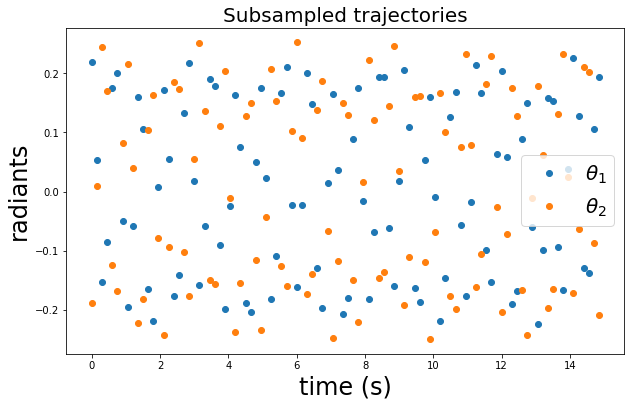

In [8]:
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot( np.arange(X[1000:1100,0].shape[0])*sampling_dt,X[1000:1100,0],"o",label = r"$\theta_1$")
ax.plot( np.arange(X[1000:1100,0].shape[0])*sampling_dt,X[1000:1100,2],"o",label = r"$\theta_2$")
plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)
plt.title("Subsampled trajectories",fontsize=20)

In [9]:
# Data preprocessing
X = torch.tensor(np.array(X), dtype=torch.float32, device=device)
num_samples = X.shape[0]
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

In [10]:
total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 12000/2000/6000


In [11]:
# Start
model_type = "paper"
if model_type not in model_info:
    lr = 0.001
    shared = False
    constraint = 0.0
    scale = 1.0
    beta_param = [1.0]
    alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
    model_params = {}

else:
    model_params = model_info[model_type]
    lr = model_params['lr'] if 'lr' in model_params else 0.001
    shared = model_params['shared'] if 'shared' in model_params else False
    constraint = model_params['constraint'] if 'constraint' in model_params else 0.0
    scale = model_params['scale'] if 'scale' in model_params else 1.0
    beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
    if len(beta_param) == 1:
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
    elif len(beta_param) == 2:
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))

print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}, constraint: {}, seed: {}'
    .format(model_type, scale, beta_param, lr, constraint, seed))


model_type: paper	scale:0	Beta distribution: Beta([0.1])	lr: 0.001, constraint: 0.0, seed: 42


In [12]:
# seed to help reproducibility. Please use a fixed initial condition per the pendulum or save the dataset
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
merge = 'cat'

In [14]:
#   input_dim = 4
input_dim_encoder = 16
output_dim_encoder = 64
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim = input_dim
n_layers = 2

In [15]:
rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

total parameters: 28692


In [17]:
loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
l1_func = nn.L1Loss()
best_val_loss = float('inf')
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
epochnum = 500
early_stopping_thld = 10
counter_early_stopping = 1
valid_freq = 5
saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                      .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)

saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))

saved_filename: saved_models/dp-paper_0.1856_0.0_-0.2815_0.0-seed42.skip.demo.pt



#### The network task
The task is to predict the state $(\theta_1,\theta_2,\omega_1,\omega_2)$ of the system at time $(t + \Delta t)$ give the state at time $t$. With standard paramenters $\Delta t$ is 0.1 s so 20 times larger than the $dt$ used for the simulation.
A visualization of a traing batch will follow

Text(0.5, 1.0, 'Subsampled trajectories')

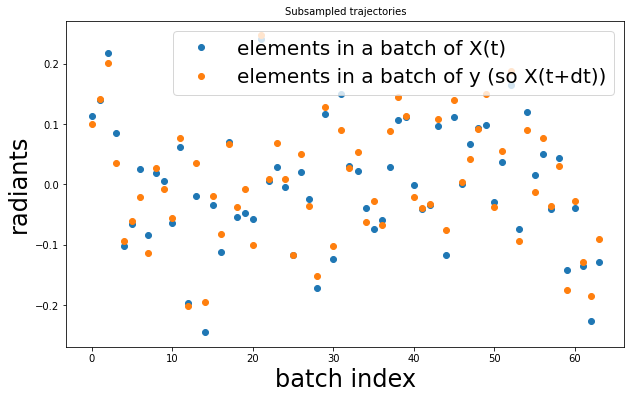

In [19]:

batch_train_x,batch_train_y = next(iter(train_loader))
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(batch_train_x.cpu().numpy()[:,2] + std_noise*np.random.randn(batch_train_x.shape[0]),'o',label="elements in a batch of X(t)")
ax.plot(batch_train_y.cpu().numpy()[:,2],'o',label="elements in a batch of y (so X(t+dt))")



plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('batch index', fontsize=24)
plt.title("Subsampled trajectories",fontsize=10)

### Training loop 
#### At each epoch (one iteration over the whole dataset)
#### The dataset is divided in mini-batches,at each step we compute the loss and update the wegths for the corrisponding data batch . So for each Step:

- data is loaded as a batch
- gradients are resetted calling optimizer.zero_grad(). If this function is not called we accumulate gradients from all the calls to loss.backward()

To utilize the **Rule Representation** we also need: 

- alpha $(\alpha)$ (the rule strength) is sampled from a beta distribution
- Energy is computed (mechanical energy of the double pendulum)

With the output and the targets we can compute the loss for the task:
- Model is called to predict outputs for the current batch (forward pass)
- "Loss Task" $L_{T}$ is computed (this loss depends only on the data provided for the batch)
- "Loss Rule" $L_{R}$ is computed (this loss depends only on our knoweledge of the physics involved)

For a naive model, the total loss $L_{total}$ would be the sum of $L_{T}$ and $L_{R}$ weigthed with a fixed contrain $\lambda$

$$
L_{total} = L_{T} + \lambda*L_{R}
$$

Instead this model is trained with a varing weigth $\alpha$ that is sampled from a given distribution at each step. Moreover a scale parameter $s$ is dinamically computed  to keep $L_{T}$ and $L_{R}$ of the same order of magnitude.


$$
L_{total} = \alpha * L_{T} + s * (1-\alpha)*L_{R}
$$

With $s =  L_{R}/ L_{T} $

With the loss we can now:
- compute the the derivative of the loss w.r.t. the parameters ("the gradients") using backpropagation calling loss.backward()
- call optimizer.step() to make a step based on the gradients 

In [20]:
# Training
ADJ_SCALE=True
for epoch in range(1, epochnum+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0] + std_noise*torch.randn(batch_data[0].shape).to(device)    # Adding noise
        batch_train_y = batch_data[1]

        optimizer.zero_grad() # Clears old gradient from last step. If this function is not called you would accumulate gradients from all the calls loss.backward()
    

 
        alpha = alpha_distribution.sample().item()

        output = model(batch_train_x, alpha=alpha)

        _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
        _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
        _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

        loss_task = loss_task_func(output, batch_train_y)    # state prediction
        loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
        loss_mae = l1_func(output, batch_train_y).item()

        if epoch>5:
            if scale == 0:
                scale = loss_rule.item() / loss_task.item()
                print('scale is updated: {}'.format(scale))
        
        loss = alpha * loss_rule + scale * (1-alpha) * loss_task

        loss.backward()
        optimizer.step()

# Evaluate on validation set
    if epoch % valid_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss_task = 0
            val_loss_rule = 0
            val_ratio = 0
            for val_x, val_y in valid_loader:
                val_x += 0.01*torch.randn(val_x.shape).to(device)
                output = model(val_x, alpha=0.0)
                _, _, curr_E = calc_double_E(val_x, **dp_params)
                _, _, pred_E = calc_double_E(output, **dp_params)

                val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)

                scale_val = val_loss_rule / val_loss_task
                if ADJ_SCALE:
                    if (torch.abs(scale_val) > 10) | (torch.abs(scale_val) < 0.1):
                        scale = val_loss_rule / val_loss_task
                        print('scale is updated dinamically from validation: {}'.format(scale))
                
            if val_loss_task < best_val_loss:
                counter_early_stopping = 1
                best_val_loss = val_loss_task
                print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} Scale_val: {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                          .format(epoch, best_val_loss, val_loss_rule, val_ratio,scale_val))
                torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                }, saved_filename)
            else:
                print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} Scale_val: {:.3f} (alpha: 0.0) ({}/{})'
                  .format(epoch, val_loss_task, val_loss_rule, val_ratio ,scale_val , counter_early_stopping, early_stopping_thld))
            if counter_early_stopping >= early_stopping_thld:
                break
            else:
                counter_early_stopping += 1


scale is updated dinamically from validation: 0.058847494423389435
[Valid] Epoch: 5 Loss(Task): 0.011312 Loss(Rule): 0.000666  Ratio(Rule): 0.733 Scale_val: 0.059 (alpha: 0.0)	 best model is updated %%%%
scale is updated dinamically from validation: 0.01418459601700306
[Valid] Epoch: 10 Loss(Task): 0.008516 Loss(Rule): 0.000121  Ratio(Rule): 0.926 Scale_val: 0.014 (alpha: 0.0)	 best model is updated %%%%
scale is updated dinamically from validation: 0.0066675483249127865
[Valid] Epoch: 15 Loss(Task): 0.008975 Loss(Rule): 0.000060 Ratio(Rule): 0.964 Scale_val: 0.007 (alpha: 0.0) (2/10)
scale is updated dinamically from validation: 0.008225222118198872
[Valid] Epoch: 20 Loss(Task): 0.011731 Loss(Rule): 0.000096 Ratio(Rule): 0.962 Scale_val: 0.008 (alpha: 0.0) (3/10)
scale is updated dinamically from validation: 0.00034506202791817486
[Valid] Epoch: 25 Loss(Task): 0.009194 Loss(Rule): 0.000003 Ratio(Rule): 0.994 Scale_val: 0.000 (alpha: 0.0) (4/10)
scale is updated dinamically from valida

In [21]:
# Test
  
rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    test_loss_task = 0
    for test_x, test_y in test_loader:
        output = model_eval(test_x, alpha=0.0)
        test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

  # Best model
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
val_vs_a = np.zeros(len(alphas))
for k,alpha in enumerate(alphas):
    model_eval.eval()
    with torch.no_grad():
        test_loss_task, test_ratio = 0, 0
        for test_x, test_y in test_loader:

            output = model_eval(test_x, alpha=alpha)

            test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

            _, _, curr_E = calc_double_E(test_x, **dp_params)
            _, _, next_E = calc_double_E(test_y, **dp_params)
            _, _, pred_E = calc_double_E(output, **dp_params)

            test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * test_x.shape[0] / total_test_sample)
        val_vs_a[k]=test_loss_task
        print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
        print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))


best model loss: 0.008516	 at epoch: 10

Test set: Average loss: 0.00280753

Test set: Average loss: 0.00280753 (alpha:0.0)
ratio of verified predictions: 0.855167 (alpha:0.0)
Test set: Average loss: 0.00245349 (alpha:0.1)
ratio of verified predictions: 0.905500 (alpha:0.1)
Test set: Average loss: 0.00228183 (alpha:0.2)
ratio of verified predictions: 0.945500 (alpha:0.2)
Test set: Average loss: 0.00229171 (alpha:0.3)
ratio of verified predictions: 0.972833 (alpha:0.3)
Test set: Average loss: 0.00242983 (alpha:0.4)
ratio of verified predictions: 0.985667 (alpha:0.4)
Test set: Average loss: 0.00270167 (alpha:0.5)
ratio of verified predictions: 0.991333 (alpha:0.5)
Test set: Average loss: 0.00301923 (alpha:0.6)
ratio of verified predictions: 0.995833 (alpha:0.6)
Test set: Average loss: 0.00330742 (alpha:0.7)
ratio of verified predictions: 0.999333 (alpha:0.7)
Test set: Average loss: 0.00363957 (alpha:0.8)
ratio of verified predictions: 1.000000 (alpha:0.8)
Test set: Average loss: 0.003983

Text(0.5, 1.0, 'Best apha value for the task')

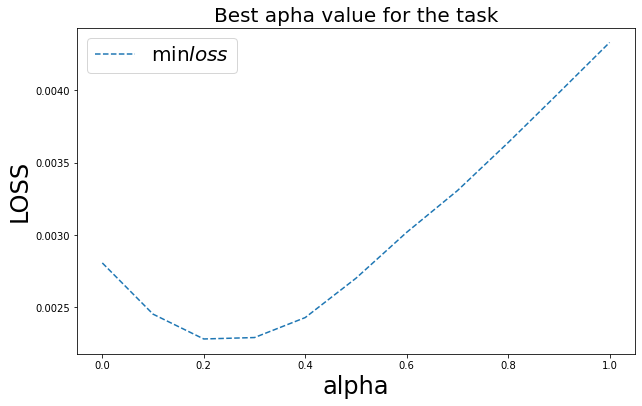

In [22]:

fig, ax = plt.subplots(figsize=[10, 6])
plt.plot(alphas,val_vs_a,"--",label = "min loss")

plt.legend(fontsize=20)
ax.set_ylabel('LOSS', fontsize=24)
ax.set_xlabel('alpha', fontsize=24)
plt.title("Best apha value for the task",fontsize=20)

In [23]:
# select the best alpha and reconstruct a trajectory
best_alpha = alphas[val_vs_a.argmin()]

In [31]:
test_trajectory=[]
reconstructed_trajectory=[]
model_eval.eval()
with torch.no_grad():        
    for test_x, test_y in test_loader:
        output = model_eval(test_x, alpha=best_alpha)
        test_trajectory.append(test_y.cpu().numpy())
        reconstructed_trajectory.append(output.cpu().numpy())

In [34]:
reconstructed_trajectory=np.squeeze(np.array(reconstructed_trajectory))
test_trajectory=np.squeeze(np.array(test_trajectory))
reconstructed_trajectory.shape

(6000, 4)

Text(0.5, 0, 'time (s)')

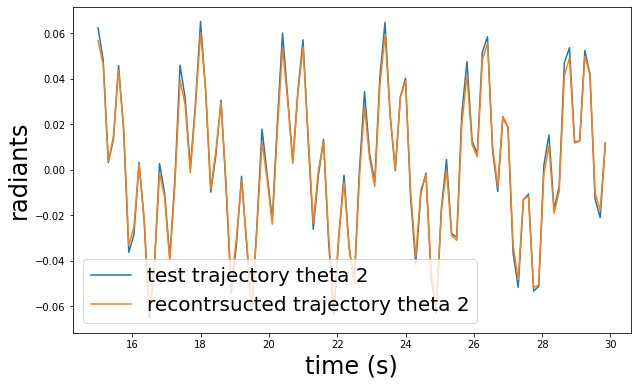

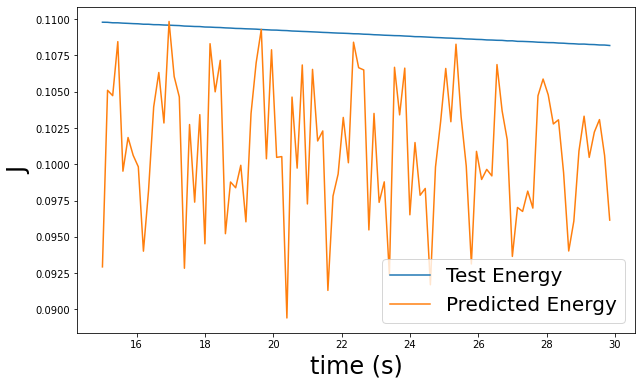

In [39]:
x_time = np.arange(test_trajectory.shape[0])*sampling_dt
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[100:200],test_trajectory[100:200,2],label = "test trajectory theta 2")
ax.plot(x_time[100:200],reconstructed_trajectory[100:200,2],label = "recontrsucted trajectory theta 2")
plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)

_, _, real_E = calc_double_E(test_trajectory[100:200,:], **dp_params)
_, _, pred_E = calc_double_E(reconstructed_trajectory[100:200,:], **dp_params)

fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[100:200],real_E,label = "Test Energy")
ax.plot(x_time[100:200],pred_E,label = "Predicted Energy")

plt.legend(fontsize=20)
ax.set_ylabel('J', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)